<a href="https://colab.research.google.com/github/ma7moudjadallah/Colab_Code_Scraping/blob/main/Optimize_The_final_version_of_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Total issues scraped: 500
Top 5 Labels:
activerecord               241
attached PR                191
With reproduction steps    181
pinned                      57
actionpack                  54
Name: count, dtype: int64
Most Popular Category (Label): activerecord


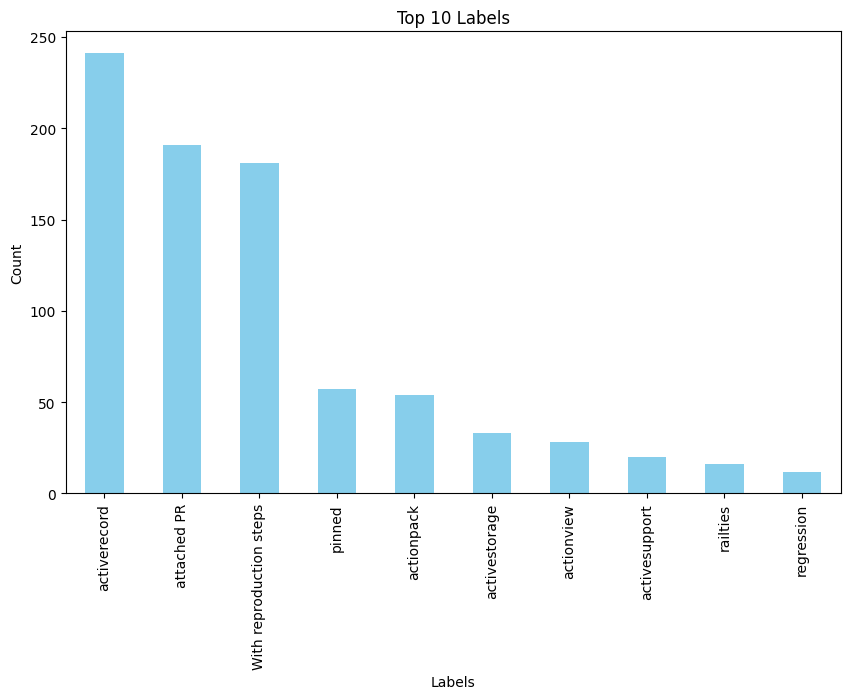

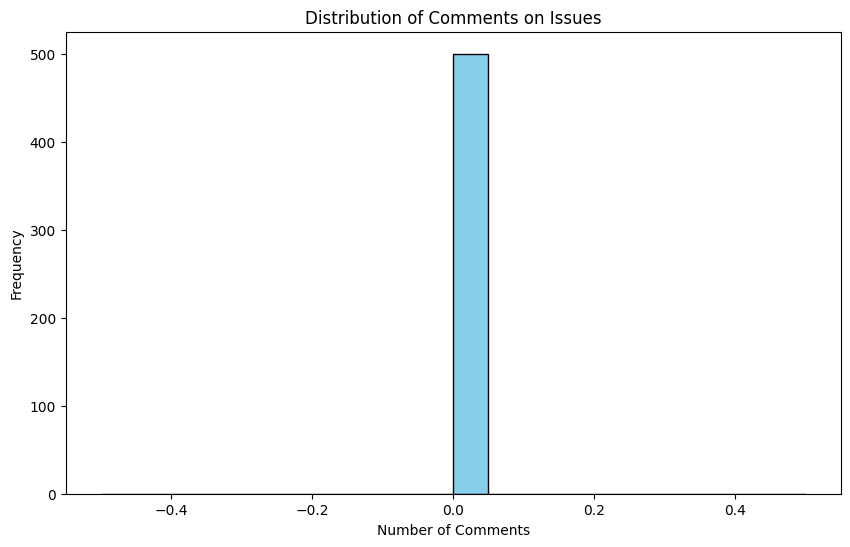

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline

def fetch_page(url, page):
    """Fetches a page of issues from GitHub."""
    try:
        response = requests.get(f"{url}?page={page}")
        response.raise_for_status()
        return response.text
    except requests.RequestException as e:
        print(f"Error fetching page {page}: {e}")
        return None

def parse_issues(html):
    """Parses the HTML content and extracts issue details."""
    soup = BeautifulSoup(html, 'html.parser')
    issue_elements = soup.find_all('div', class_='js-issue-row')
    issues = []
    for element in issue_elements:
        title_element = element.find('a', class_='Link--primary')
        title = title_element.get_text().strip() if title_element else 'No title'

        labels = [label.get_text().strip() for label in element.find_all('a', class_='IssueLabel')]

        comments_span = element.find('span', class_='Counter')
        comments = int(comments_span.get_text().strip()) if comments_span else 0

        issues.append({'title': title, 'labels': labels, 'comments': comments})
    return issues

def scrape_issues(url, num_issues=500):
    """Scrapes issues from the given GitHub repository URL."""
    issues = []
    page = 1
    while len(issues) < num_issues:
        html = fetch_page(url, page)
        if not html:
            break
        page_issues = parse_issues(html)
        if not page_issues:
            break
        issues.extend(page_issues)
        page += 1
    return issues[:num_issues]

def perform_eda(issues):
    """Performs exploratory data analysis on the issues."""
    df = pd.DataFrame(issues)
    print(f"Total issues scraped: {len(df)}")

    all_labels = [label for labels in df['labels'] for label in labels]
    if all_labels:
        label_counts = pd.Series(all_labels).value_counts()
        print("Top 5 Labels:")
        print(label_counts.head(5))
        popular_category = label_counts.idxmax()
        print("Most Popular Category (Label):", popular_category)

        label_counts.head(10).plot(kind='bar', figsize=(10, 6), color='skyblue')
        plt.title('Top 10 Labels')
        plt.xlabel('Labels')
        plt.ylabel('Count')
        plt.show()

    if 'comments' in df.columns:
        df['comments'].plot(kind='hist', bins=20, figsize=(10, 6), color='skyblue', edgecolor='black')
        plt.title('Distribution of Comments on Issues')
        plt.xlabel('Number of Comments')
        plt.ylabel('Frequency')
        plt.show()

def classify_issues(issues):
    """Classifies issues using a zero-shot classification model."""
    classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
    descriptions = [issue['title'] for issue in issues]
    candidate_labels = list(set([label for issue in issues for label in issue['labels']]))
    classifications = classifier(descriptions, candidate_labels=candidate_labels)

    summarized_classifications = []
    for i, classification in enumerate(classifications):
        result = {
            'title': issues[i]['title'],
            'label': classification['labels'][0],
            'score': classification['scores'][0]
        }
        summarized_classifications.append(result)

    return summarized_classifications

def display_classified_issues(classified_issues, num_display=10):
    """Displays a summary of the classified issues."""
    print("Classified Issues:")
    for classified_issue in classified_issues[:num_display]:
        print(f"Title: {classified_issue['title']}")
        print(f"Predicted Label: {classified_issue['label']}")
        print(f"Confidence Score: {classified_issue['score']:.2f}")
        print("-" * 50)

def main():
    url = "https://github.com/rails/rails/issues"
    issues = scrape_issues(url)
    if issues:
        perform_eda(issues)
        classified_issues = classify_issues(issues)
        display_classified_issues(classified_issues)

if __name__ == "__main__":
    main()
